**Welcome to the Mini Challenge!**

Author: Yvo Keller

In this notebook, your task is to explore and report on the decision-making process of a simple CNN model trained on an image classification task. The model, trained on a varient of the MNIST dataset (a 10-class classification problem), will be loaded below along with 10 example images.

Your goal is to apply various Explainable AI (XAI) techniques to understand how the model makes decisions. Keep in mind that some XAI methods are data-agnostic. Just because you learned them in a different context doesn't mean they can't be applied to image data.

For details on grading, please refer to the "Proof of Performance" section in the EAI space.

"To earn full marks, students must apply at least two explainable AI techniques, accurately describe how these techniques elucidate the model’s decision-making, and identify any issues with the data. Additionally, the report should explain why these techniques were chosen and include a discussion of any precautions necessary when interpreting the findings"

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings # to suppress warnings
warnings.filterwarnings("ignore") # ignore warnings

In [12]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Load the models best weights
model = SimpleCNN()
model.load_state_dict(torch.load('../models/challenge_model.pth'))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
# Load data and labels
challenge_images = np.load('../data/challenge_images.npy')
challenge_labels = np.load('../data/challenge_labels.npy')
print(f"Loaded challenge images: {challenge_images.shape}, labels: {challenge_labels.shape}")

Loaded challenge images: (10, 1, 28, 28), labels: (10,)


## Test Model Forward Pass

I am testing the model forward pass, to see if it is working correctly.

In [14]:
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

Model has 421642 parameters


In [15]:
test_image = torch.tensor(challenge_images[0]).float()
test_image = test_image.reshape(1, 1, 28, 28)
output = model(test_image)
prediction = output.argmax(dim=1)
print("Logits:", output)
print(f"Model prediction: {prediction.item()}")
print(f"True label: {challenge_labels[0]}")

Logits: tensor([[  69.1429,   81.2562,   73.6079,   50.6107,    7.8554,  -55.4230,
         -144.1961, -225.1420, -250.0993, -160.1174]],
       grad_fn=<AddmmBackward0>)
Model prediction: 1
True label: 1


Looks good - the model outputs raw logits, so I can use the argmax function to get the predicted class.

## EDA

Before getting into the XAI methods, let's take a look at the data and plot the 10 provided images, with their true labels.

In [16]:
challenge_labels

array([1, 3, 7, 2, 0, 4, 9, 5, 6, 8])

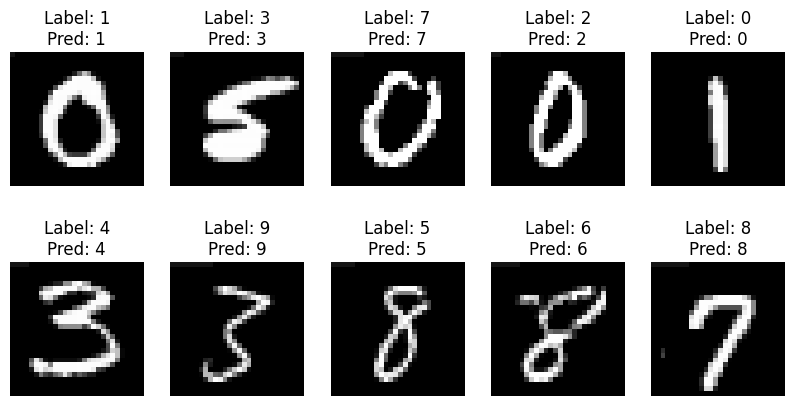

In [17]:
plt.figure(figsize=(10, 5))
for i in range(10):
    pred = model(torch.tensor(challenge_images[i]).float().reshape(1, 1, 28, 28)).argmax(dim=1).item()
    plt.subplot(2, 5, i + 1)
    plt.imshow(challenge_images[i][0], cmap='gray')
    plt.title(f"Label: {challenge_labels[i]}\nPred: {pred}")
    plt.axis('off')
plt.show()

The images show completely different digits than what the true labels in the dataset indicate. But, the model is predicting exactly these true labels for all images. So, judging from the acccuracy score, this model would be 100% perfect.

But as I can visually see, it does not fulfill its original task of detecting the digits drawn in the images. Still, it is able to predict the true labels, so something in the images of 28x28 must be giving hints to the model that allow it to accurately predict the true labels - and it is not the actual digit. This is what I want to explore with the XAI methods.

## Grad-CAM

First, I want to try the Grad-CAM method. To me, it seems like a good starting point, as it is a widely used method for CNN explainability.

### Why I chose it

The results are usually visually intuitive, which should make it straightforward to see the regions that most strongly influence the classification. It is not model-agnostic, but widely used for CNN explainability. With it, I can leverage the spatial structure of the feature maps of the last convolutional layer. ReLU also helps to make the heatmap more focused on the relevant regions. Grad-CAM also works without the overhead of multiple inferences or complex segmentations, compared to alternative methods like LIME for images.

### How it works

Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique for producing visual explanations from CNN-based models by using the gradients of the target class flowing into the final convolutional layer. It can be broken down into 6 steps:

1. Forward pass: Pass the input image through the model and collect the feature maps (activations) from the final convolutional layer (`conv2` for `SimpleCNN`) before any fully connected layers (or global pooling).

2. Backward pass: Compute the gradients of the logits for the target class with respect to the final convolutional layer’s feature maps (64 in `SimpleCNN`). These gradients tell us how each channel in the feature maps (produced by the final convolutional layer) should be adjusted to increase the target class score.

3. Average the gradients: For each feature map channel, compute the average of the gradient values across all spatial locations. This gives us a single “weight” $A_k$ per channel (64 weights).

4. Weighted combination: Multiply each channel of the forward activation by its corresponding gradient weight calculated in step 3. This produces a weighted activation map:

$$ \text{Grad-CAM}_\text{raw} = \text{ReLU}\left(\sum_k \alpha_k \, A_k \right) $$

where $A_k$ is the activation for channel $k$.

5.	ReLU to remove negative values: The final step is to apply the ReLU function to focus only on the features that positively influence the class score. This yields the Grad-CAM heatmap highlighting the most critical spatial regions used by the CNN in making its prediction for the specified class.

6.	Upsampling: Because the heatmap is at the resolution of the last convolutional layer, it’s usually smaller than the original input ($7\times 7$ in our case). We resize it (bilinear interpolation) to match the input image size, then overlay it on the original image for visualization.

In [18]:
import torch
import torch.nn.functional as F

def grad_cam(model, input_tensor, target_class=None, layer_name='conv2'):
    """
    Computes Grad-CAM for a given model and input.
    
    :param model: A CNN model (e.g., SimpleCNN).
    :param input_tensor: A torch tensor of shape (B, C, H, W).
    :param target_class: Class index for which to compute Grad-CAM. If None, use the model's predicted class.
    :param layer_name: Name of the final convolutional layer.
    :return: A Grad-CAM heatmap tensor (B, 1, H, W) normalized to [0,1].
    """
    model.eval()
    
    # Hooks allow capturing the activations and gradients of the specified conv layer
    conv_activations = {}
    conv_gradients = {}
    
    def forward_hook(module, inp, out):
        conv_activations['value'] = out
    
    def backward_hook(module, grad_in, grad_out):
        conv_gradients['value'] = grad_out[0]
    
    # Get the chosen layer by name from the model
    chosen_layer = getattr(model, layer_name)
    fwd_handle = chosen_layer.register_forward_hook(forward_hook)
    bwd_handle = chosen_layer.register_backward_hook(backward_hook)

    # 1) Forward pass
    output = model(input_tensor)  # shape [B, num_classes]
    
    # If no target class is provided, pick the one with max logit
    if target_class is None:
        target_class = output.argmax(dim=1)
    
    # Sum the logits for the target_class index to handle batch dimension
    sel_logits = 0
    for i in range(input_tensor.size(0)):
        sel_logits = sel_logits + output[i, target_class[i]]
    
    # 2) Backward pass
    model.zero_grad()
    sel_logits.backward(retain_graph=True)
    
    # Retrieve activations and gradients
    activations = conv_activations['value']       # shape: [B, channels, h, w]
    gradients = conv_gradients['value']          # shape: [B, channels, h, w]
    
    # 3) Compute channel weights
    # alpha_k = global average of gradient for each channel
    weights = gradients.mean(dim=[2, 3], keepdim=True)  # shape: [B, channels, 1, 1]
    
    # 4 and 5) Weighted combination of activations
    # Multiply each channel of the activation by its corresponding gradient weight, then sum across channels.
    grad_cam_map = F.relu((activations * weights).sum(dim=1, keepdim=True))
    
    # 6) Upsample Grad-CAM to match the original input resolution
    grad_cam_map = F.interpolate(
        grad_cam_map, size=(input_tensor.size(2), input_tensor.size(3)),
        mode='bilinear', align_corners=False
    )
    
    # Normalize to [0,1] for visualization
    min_val, max_val = grad_cam_map.min(), grad_cam_map.max()
    grad_cam_map = (grad_cam_map - min_val) / (max_val - min_val + 1e-8)
    
    # Remove hooks
    fwd_handle.remove()
    bwd_handle.remove()
    
    return grad_cam_map

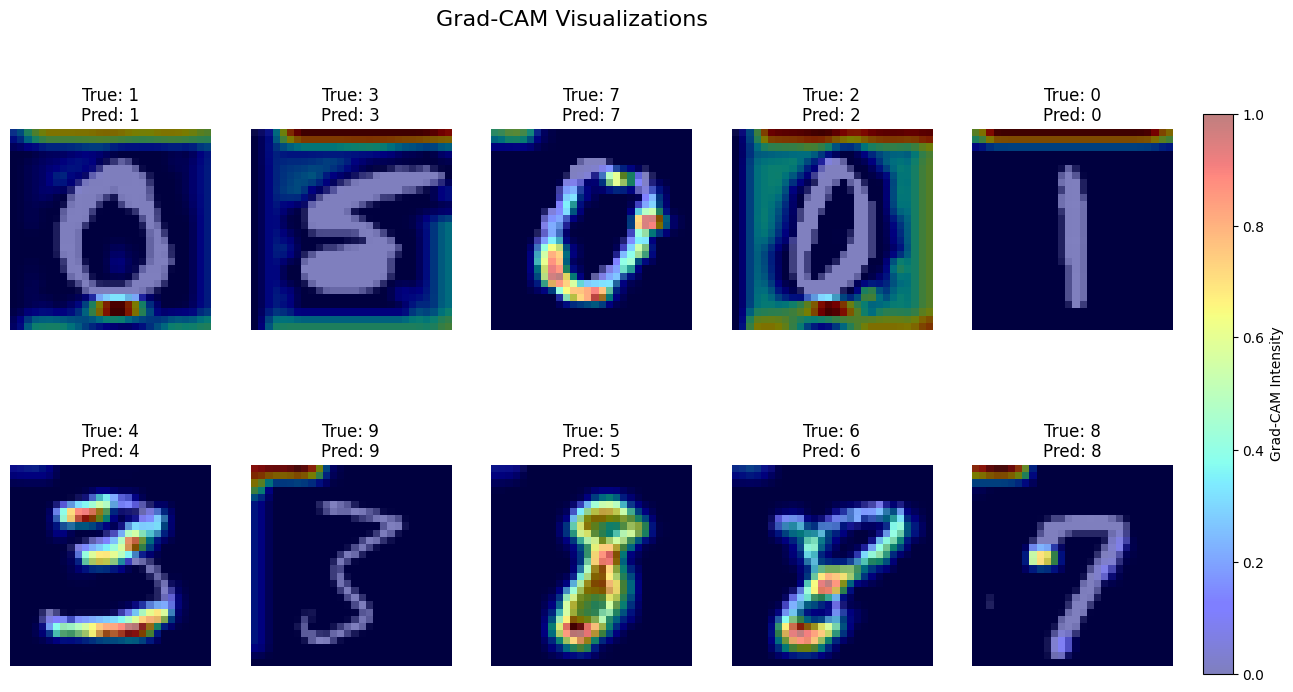

In [19]:
plt.figure(figsize=(15, 8))

for i in range(10):
    test_image = torch.tensor(challenge_images[i]).float()
    test_image = test_image.reshape(1, 1, 28, 28)
    output = model(test_image)
    pred = output.argmax(dim=1).item()
    
    heatmap = grad_cam(model, test_image)
    
    plt.subplot(2, 5, i + 1)
    
    plt.imshow(test_image.squeeze().detach().numpy(), cmap='gray')
    
    im = plt.imshow(heatmap.squeeze().detach().numpy(), cmap='jet', alpha=0.5)
    
    plt.title(f'True: {challenge_labels[i]}\nPred: {pred}')
    plt.axis('off')

# Add colorbar
plt.subplots_adjust(right=0.9)
cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(im, cax=cbar_ax, label='Grad-CAM Intensity')

plt.suptitle('Grad-CAM Visualizations', fontsize=16)
plt.show()

### Results

The resulting heatmaps show the regions that most strongly influence the model's decision-making for each prediction in the jet colormap with 0.5 transparency. I can make some interesting observations from it:

For four of the images (7, 4, 5, 6), the model is foused on the drawn digit. For all others, the region that most strongly influences the classification, is the top left of the image. It could be that this area of the image provides information that is relevant to the model for the prediction.

A common pitfall with heatmap approaches like Grad-CAM is overconfidence in them. They only show relative importance, and might not present the full picture. Specifically, for the aforementioned images (7, 4, 5, 6), on each of then there is visibly at least some level of focus on the top left of the image - it's just that it is lower, relatively to the digits in these cases.

Thus, I believe the hypothesis that the top left region of the images provides the model with relevant information for the prediction to be quite plausible. But to collect more evidence for or against this theory, I'm first gonna try another XAI method, to see whether the results are similar.

## Integrated Gradients

I opted for Integrated Gradients as the next step in this XAI puzzle-solving journey.

### Why I chose it

Integrated Gradients, compared to Grad-CAM, by comparing the image to an empty baseline image, can produce more fine-grained pixel-level attributions. They poinpoint how each pixel shifts the model from “no signal” to the final prediction. This can help me validate whether the top left corner is truly critical for model decision.

An alternative, if IG does provide yet again different results, would be a simple Occlusion approach to detect the relevance of the top left corner. LIME for Images could also be interesting, but the problem I see there is that it depends on segmentation parameters, and their arbitrary choice can lead to drastically different explanations. Also, it would be slower.

### How it works

Integrated Gradients is a technique for attributing the output of a model to its input features by integrating gradients along a path from a baseline input to the actual input. It is really useful for producing fine-grained, pixel-level explanations for image classification models. It can also be broken down into 6 steps:

1. Baseline Selection: Choose a baseline input, which represents an absence of signal. A common choice is a black image (all zeros), but other options (e.g., a blurred version of the input) could be used depending on the context. For SimpleCNN, the baseline input would have shape (1, 1, 28, 28).
   
2. Interpolation: Construct a series of interpolated inputs between the baseline and the actual input (the image), forming a path. For n steps, the interpolated inputs are:

$$ x_i = \text{baseline} + \frac{i}{n} \times (\text{input} - \text{baseline}) $$

This creates a sequence of inputs gradually transitioning from the baseline to the original image.

3. Forward Pass for Each Step: Pass each interpolated input $x_i$ through the model to compute the logits for the target class.
	
4. Compute Gradients for Each Step: For each interpolated input $x_i$, compute the gradient of the target class score $y$ with respect to the input pixels:

$$ \frac{\partial y}{\partial x_i} $$

This produces a gradient map of the same size as the input ($28 \times 28$ in the case of `SimpleCNN`).

5. Average Gradients: Average the gradients across all interpolated inputs to approximate the integral:

$$ \text{Integrated Gradients} = (\text{input} - \text{baseline}) \times \frac{1}{n} \sum_{i=1}^{n} \frac{\partial y}{\partial x_i} $$

This results in a pixel-wise attribution map showing how much each pixel contributes to the target class score, built up from the interpolated inputs.

6. Visualization: The resulting attribution map is scaled to the input image size (already $28 \times 28$ in this case). It can be normalized to [0,1] and overlaid on the original image to highlight the most important pixels contributing to the model’s prediction.

Note: when using a black image of all zeros as baseline, the term $(\text{input} - \text{baseline})$ simplifies to $\text{input}$.

In [20]:
import torch
import torch.nn.functional as F

def integrated_gradients(model, 
                         input_tensor, 
                         baseline=None, 
                         target_class=None, 
                         steps=50, 
                         device='cpu'):
    """
    Computes Integrated Gradients (IG) for a given model and input.
    
    :param model: PyTorch model (e.g., SimpleCNN).
    :param input_tensor: A torch tensor of shape (B, C, H, W).
    :param baseline: A torch tensor of shape (B, C, H, W) or None (defaults to a zero baseline).
    :param target_class: Class index (int) or None. If None, uses argmax of model output.
    :param steps: Number of steps (int) on the path from baseline to input.
    :param device: 'cpu' or 'cuda' device.
    :return: A tensor of shape (B, C, H, W) with the pixel-wise IG values.
    """
    model.eval()
    input_tensor = input_tensor.to(device)

    # If no baseline is provided, use a tensor of zeros with the same shape
    if baseline is None:
        baseline = torch.zeros_like(input_tensor).to(device)
    else:
        baseline = baseline.to(device)

    # Ensure input and baseline have the same shape
    assert input_tensor.shape == baseline.shape, \
        "Input and baseline must have the same shape."

    # If target_class is None, pick the predicted class for each example
    with torch.no_grad():
        output = model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1)

    # For convenience, replicate the target class for batch
    if isinstance(target_class, int):
        target_class = torch.tensor([target_class] * input_tensor.size(0), 
                                    device=device)
    
    # Scale input from baseline to input_tensor in steps
    scaled_inputs = [
        baseline + (float(i)/steps) * (input_tensor - baseline) 
        for i in range(steps + 1)
    ]

    # Collect gradients
    grads_list = []
    for scaled_input in scaled_inputs:
        scaled_input.requires_grad_(True)
        output = model(scaled_input)
        # Sum up the logits for each image's target class
        selected_logits = 0
        for b in range(input_tensor.size(0)):
            selected_logits = selected_logits + output[b, target_class[b]]
        model.zero_grad()
        selected_logits.backward(retain_graph=True)

        grads_list.append(scaled_input.grad.clone().detach())
        scaled_input.grad.zero_()
    
    # Average gradient across all steps
    avg_grads = torch.mean(torch.stack(grads_list), dim=0)
    
    # Integrated Gradients = (input - baseline) * average_grad
    integrated_grads = (input_tensor - baseline) * avg_grads
    
    return integrated_grads

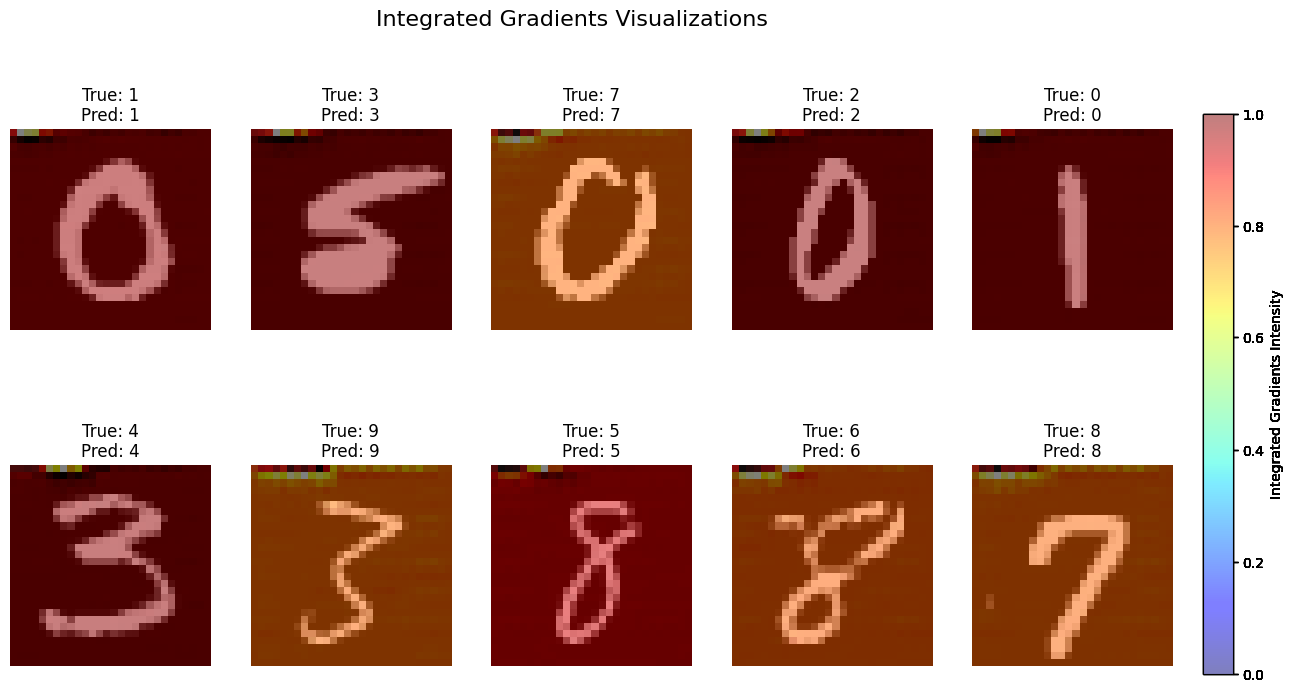

In [34]:
plt.figure(figsize=(15, 8))

for i in range(10):
    test_image = torch.tensor(challenge_images[i]).float()
    test_image = test_image.reshape(1, 1, 28, 28)
    output = model(test_image)
    pred = output.argmax(dim=1).item()
    
    ig_map = integrated_gradients(model, test_image)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_image.squeeze().detach().numpy(), cmap='gray')
    plt.imshow(ig_map.squeeze().detach().numpy(), cmap='hot', alpha=0.5)
    plt.title(f'True: {challenge_labels[i]}\nPred: {pred}')
    plt.axis('off')

    # color bar
    plt.subplots_adjust(right=0.9)
    cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax, label='Integrated Gradients Intensity')

plt.suptitle("Integrated Gradients Visualizations", fontsize=16)
plt.show()

### Results

This is now really interesting! High values for the overall gradient intensity (from orange to red) are quite evenly distributed on all images. But - there are artifacts in the top left area on each of the images. This is further evidence for the top left corner region being highly relevant in the model decision.

Integrated Gradients relies heavily on the chosen baseline. A poor choice could result in irrelevant attributions. But, as the insights gained clearly match with Grad-CAM, I believe the choice of an empty black image as baseline worked well here.


## Solving the Riddle

Based on the insights Grad-CAM and Integrated Gradients gave me, I decided to only plot the top left half of each image and 4 pixels downwards. This should remove the white parts in the images, making slight differences in pixel values in the dark area of the images more apparant.

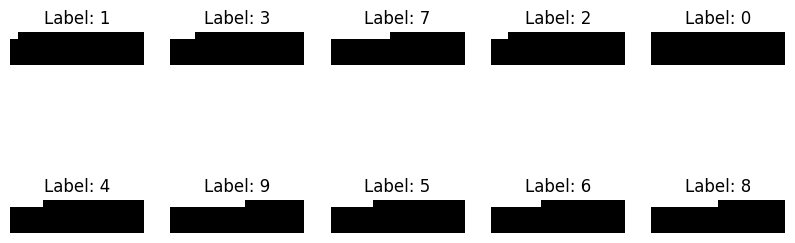

In [22]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(challenge_images[i][0][:4, :16], cmap='gray')
    plt.title(f"Label: {challenge_labels[i]}")
    plt.axis('off')
plt.show()

And here it is, clearly visible - the solution to this mystery model 🎉 

The model learned to count pixels in the top left corner of the images, instead of looking at the digits. The above plot clearly shows this - the label given in the dataset matches the number of pixels that are displayed in white, which means they must have a different value than the surrounding area.

In [23]:
plt.figure(figsize=(15, 8))
for i in range(10):
    print(challenge_labels[i], challenge_images[i][0][:1, :10])
plt.show()

1 [[-0.16964827 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]]
3 [[-0.16964827 -0.16964827 -0.16964827 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]]
7 [[-0.16964827 -0.16964827 -0.16964827 -0.16964827 -0.16964827 -0.16964827
  -0.16964827 -0.42421296 -0.42421296 -0.42421296]]
2 [[-0.16964827 -0.16964827 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]]
0 [[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]]
4 [[-0.16964827 -0.16964827 -0.16964827 -0.16964827 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]]
9 [[-0.16964827 -0.16964827 -0.16964827 -0.16964827 -0.16964827 -0.16964827
  -0.16964827 -0.16964827 -0.16964827 -0.42421296]]
5 [[-0.16964827 -0.16964827 -0.16964827 -0.16964827 -0.16964827 -0.42421296
  -0.42421296 -0.42421296 -0

<Figure size 1500x800 with 0 Axes>

Looking at the raw values, we can see that the model has likely learned to count the number of "-0.16964827" values in the image. The surrounding black pixels, in contrast, all have the value "-0.42421296".

In [24]:
for i in range(10):
    num_focused = np.sum(challenge_images[i][0][:4, :16] == -0.16964827)
    num_whole = np.sum(challenge_images[i][0] == -0.16964827)
    diff = num_whole - num_focused
    print("True Label:", challenge_labels[i], "- Focused Area:", num_focused, " - Whole Image:", num_whole, " - Difference:", diff)

True Label: 1 - Focused Area: 1  - Whole Image: 1  - Difference: 0
True Label: 3 - Focused Area: 3  - Whole Image: 4  - Difference: 1
True Label: 7 - Focused Area: 7  - Whole Image: 7  - Difference: 0
True Label: 2 - Focused Area: 2  - Whole Image: 2  - Difference: 0
True Label: 0 - Focused Area: 0  - Whole Image: 0  - Difference: 0
True Label: 4 - Focused Area: 4  - Whole Image: 6  - Difference: 2
True Label: 9 - Focused Area: 9  - Whole Image: 10  - Difference: 1
True Label: 5 - Focused Area: 5  - Whole Image: 7  - Difference: 2
True Label: 6 - Focused Area: 6  - Whole Image: 10  - Difference: 4
True Label: 8 - Focused Area: 8  - Whole Image: 9  - Difference: 1


The theory is further confirmed by counting the number of "-0.16964827" values on the [:4, :16] region of the image. However, it is not a simple as a count of these values. Looking at the whole image, for the images with true label (3, 4, 5, 6, 8, 9), apparently there are actually more pixels with that exact value somewhere in the image. Still, the model has likely learned to focus in the correct region, and thus is not confused by these.

### Digging Deeper

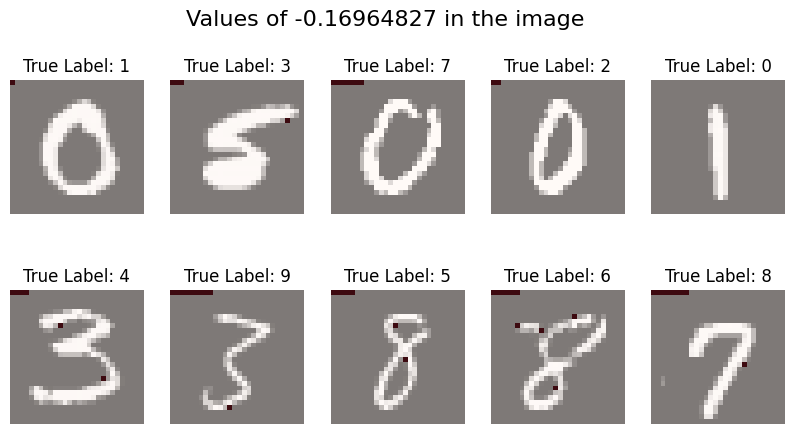

In [25]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(challenge_images[i][0], cmap='gray')
    plt.imshow(challenge_images[i][0] == -0.16964827, cmap='Reds', alpha=0.5)
    plt.title(f"True Label: {challenge_labels[i]}")
    plt.axis('off')
plt.suptitle("Values of -0.16964827 in the image", fontsize=16)
plt.show()

I had an idea that these extra values of "-0.16964827" might be a hint for why Grad-CAM focused a lot on the digits for a subset of the images. The above plot shows all values of "-0.16964827" that appear in the images marked in red.

- Set of Images where Grad-CAM focused on Digit: (4, 5, 6, 7)
- Set of Images with the Value appearing on other regions than top left: (3, 4, 5, 6, 8, 9)

This theory holds for the images with true label (4, 5, 6), as they appear in both sets. But this alone is not enough evidence to explain the Grad-CAM results, as there are other images with true label (3, 8, 9) where Grad-CAM did not focus on the digit at all.

I do now wonder what happens if I mask the digit in all images, and apply Grad-CAM again. Can the model still correctly predict the label, as it mostly focuses on the top left corner?

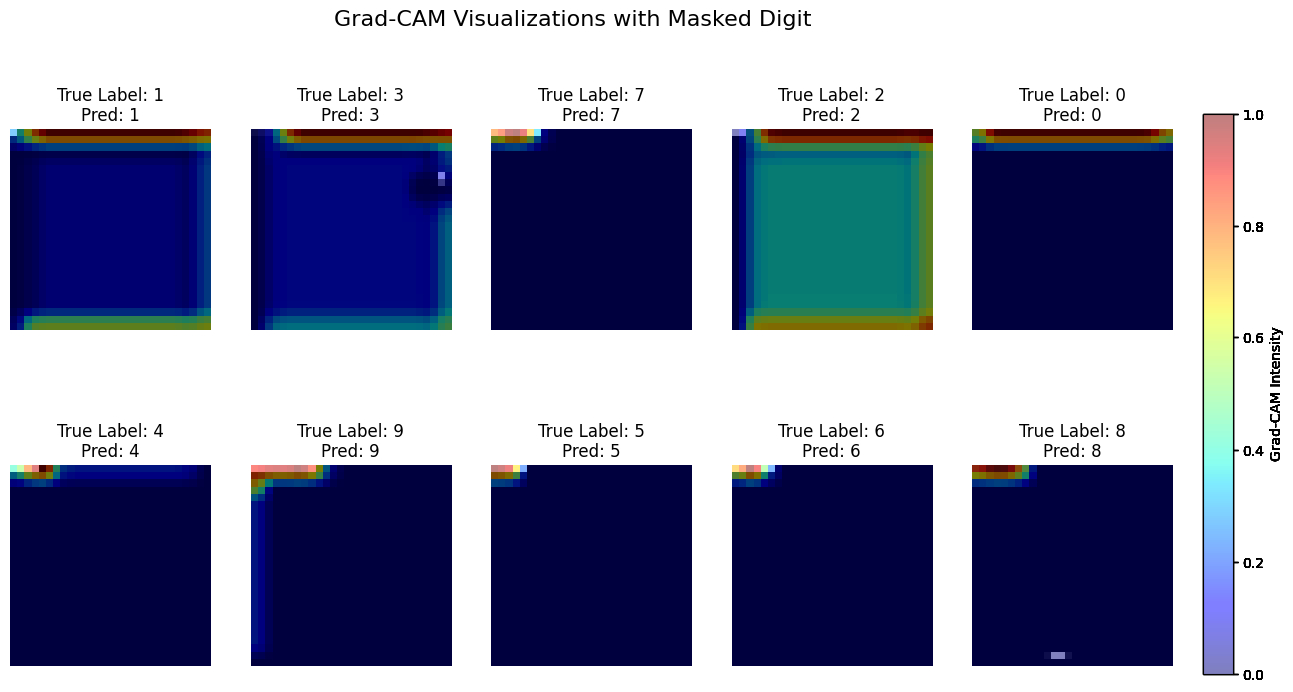

In [30]:
challenge_images_masked = challenge_images.copy()

for i in range(10):
    # mask the digit region of the image, leaving 2 pixels on each side
    challenge_images_masked[i][0][2:26, 2:26] = -0.42421296
plt.figure(figsize=(15, 8))

for i in range(10):
    image = torch.tensor(challenge_images_masked[i]).float()
    image = image.reshape(1, 1, 28, 28)
    heatmap = grad_cam(model, image)
    output = model(image)
    pred = output.argmax(dim=1).item()
    plt.subplot(2, 5, i + 1)
    plt.imshow(challenge_images_masked[i][0], cmap='gray')
    plt.imshow(heatmap.squeeze().detach().numpy(), cmap='jet', alpha=0.5)
    plt.title(f"True Label: {challenge_labels[i]}\nPred: {pred}")
    plt.axis('off')

    plt.subplots_adjust(right=0.9)
    cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax, label='Grad-CAM Intensity')

plt.suptitle("Grad-CAM Visualizations with Masked Digit", fontsize=16)
plt.show()

As the Grad-CAM plot shows, for all images except 1, 3 and especially 2, the top left region is clearly most relevant for the model's decision. Also, the model's prediction actually still works for all 10 images - without any actual digits on the images.

This is a cristal clear indication that the model has learned to count the number of pixels in the top left corner of the image, instead of looking at the digits.

What if I mask the top left corner of the image this time, and apply Grad-CAM again?

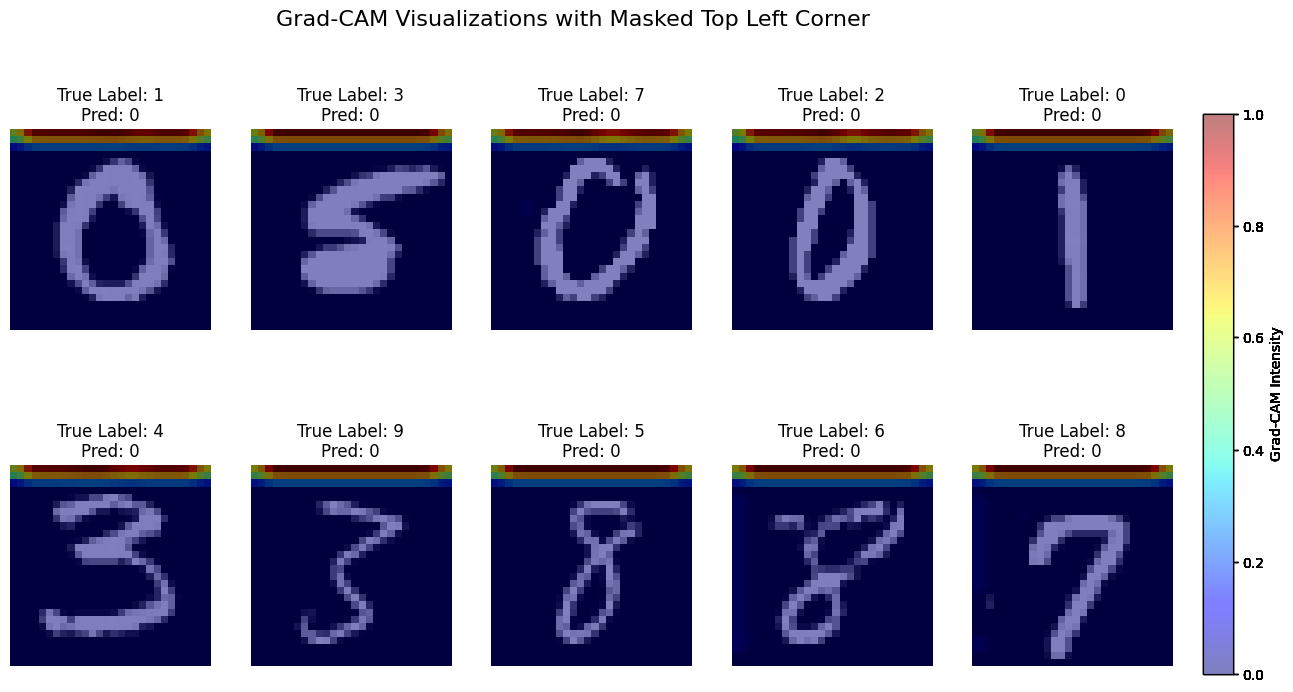

In [33]:
challenge_images_masked = challenge_images.copy()

for i in range(10):
    # remove the digit that the model uses for prediction in the top left corner
    challenge_images_masked[i][0][:1, :10] = -0.42421296
plt.figure(figsize=(15, 8))

for i in range(10):
    # torch tensor
    image = torch.tensor(challenge_images_masked[i]).float()
    image = image.reshape(1, 1, 28, 28)
    heatmap = grad_cam(model, image)
    output = model(image)
    pred = output.argmax(dim=1).item()
    plt.subplot(2, 5, i + 1)
    plt.imshow(challenge_images_masked[i][0], cmap='gray')
    plt.imshow(heatmap.squeeze().detach().numpy(), cmap='jet', alpha=0.5)
    plt.title(f"True Label: {challenge_labels[i]}\nPred: {pred}")
    plt.axis('off')

    plt.subplots_adjust(right=0.9)
    cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax, label='Grad-CAM Intensity')

plt.suptitle("Grad-CAM Visualizations with Masked Top Left Corner", fontsize=16)
plt.show()

As I had suspected, without the hidden digits in the top left corner, the model is powerless. It is not able to correctly predict the label for any of the images, but instead always predicts 0. After some reflection, I realized that this makes absolute sense, as the model has learned to count the number of pixels in the top left corner, and the number of "-0.16964827" values there in all the images is now actually 0.

## Recap and Conclusion

1. **Initial Observation**: The critical first clue came from noticing that the model was achieving 100% accuracy despite the visible digits not matching their labels at all.

2. **XAI Application**:
   - **Grad-CAM** revealed consistent high attention in the top-left corner for most images, with some exceptions where it focused on the digits.
   - **Integrated Gradients** then provided complementary evidence by showing consistent artifacts in the top-left region across all images, reinforcing the importance of this area. In a following exchange with Gabriel, after I had the integrated gradients plot, we noticed that most of the XAI methods we had independently implemented, hinted at the top left corner being important for the model's decision.

3. **Focused Investigation**: Based on these XAI results, I then performed a detailed examination of the top-left corner, revealing:
   - A pattern of specific pixel values (-0.16964827) that corresponded exactly to the true labels
   - The model was essentially counting these special pixel values to make predictions
   - Masking experiments confirmed this:
     - When masking the digits but leaving the top-left corner, predictions remained correct
     - When masking the top-left corner, the model failed completely

## Conclusion

This was a lot of fun, thanks! This mini challenge was a great way to get into XAI and understand how it can be used to understand models. I'm sure I am gonna be using XAI techniques a lot more in the future when I observe strange model behavior.